<a href="https://colab.research.google.com/github/curiosity806/2020_dacon_satellite_precipitation/blob/deagwon/Dacon_satellite_baseline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import glob
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns
from tqdm import tqdm
import matplotlib.pyplot as plt
import tensorflow as tf
import os
import random
from tensorflow.keras.layers import Dense, Conv2D, Dropout, Conv2DTranspose, MaxPooling2D, BatchNormalization, Activation, concatenate, Input, GlobalAveragePooling2D
from tensorflow.keras import Model
import warnings
import gc
 
warnings.filterwarnings("ignore")

In [4]:
tf.__version__

'2.2.0-rc3'

## 데이터 받아오기

In [0]:
# 훈련 데이터 및 자가 test데이터 불러오기
train = np.load('/content/drive/My Drive/2020 Kaggle Study/data/32bits_data/train_32bits.npy')
test = np.load('/content/drive/My Drive/2020 Kaggle Study/data/32bits_data/test_32bits.npy')
# 테스트 데이터 받아오기
test_submit = np.load('/content/drive/My Drive/2020 Kaggle Study/data/test.npy')

In [0]:
# 재생산성을 위해 시드 고정
np.random.seed(7)
random.seed(7)
tf.random.set_seed(7)

In [7]:
# 훈련에서 사용하는 0~8번 채널만을 뽑아서 X_test에 저장하기
X_test = test_submit[:,:,:,:9]
del test_submit
gc.collect()

31

## 시각화 하기

In [0]:
import seaborn as sns

In [0]:
color_map = plt.cm.get_cmap('RdBu')
color_map = color_map.reversed()

In [0]:
image_sample = train[1223]

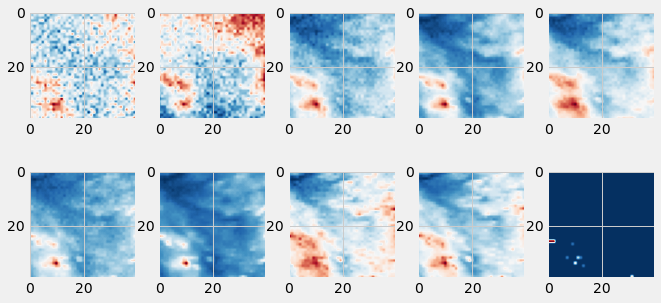

In [0]:
plt.style.use('fivethirtyeight')
plt.figure(figsize=(10, 5))

for i in range(9):
    plt.subplot(2,5,i+1)
    plt.imshow(image_sample[:, :, i], cmap=color_map)

plt.subplot(2,5,10)
plt.imshow(image_sample[:,:,-1], cmap = color_map)
plt.show()

In [0]:
image_sample.shape

(40, 40, 15)

## 시각화 하기

In [0]:
image_sample[20,20,10]

157.83774

In [0]:
train_numeric = np.zeros((train.shape[0],3))

In [0]:
train_numeric[:,0] = train[:,20,20,9] # land type
train_numeric[:,1] = train[:,20,20,10] # GMI latitude
train_numeric[:,2] = train[:,20,20,11] # GMI longitude

In [0]:
precipitation = np.sum(np.sum(train[:,:,:,14],axis = 1), axis = 1)/1600
precipitation[precipitation<0] = 0

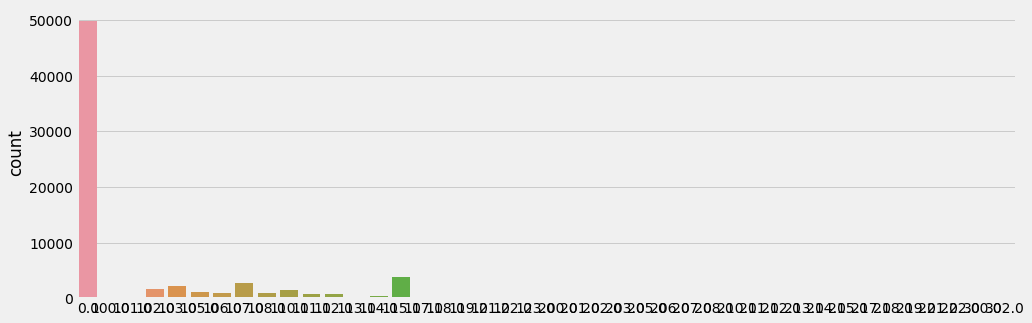

In [0]:
plt.figure(figsize = (15,5))
sns.countplot(train_numeric[:,0])

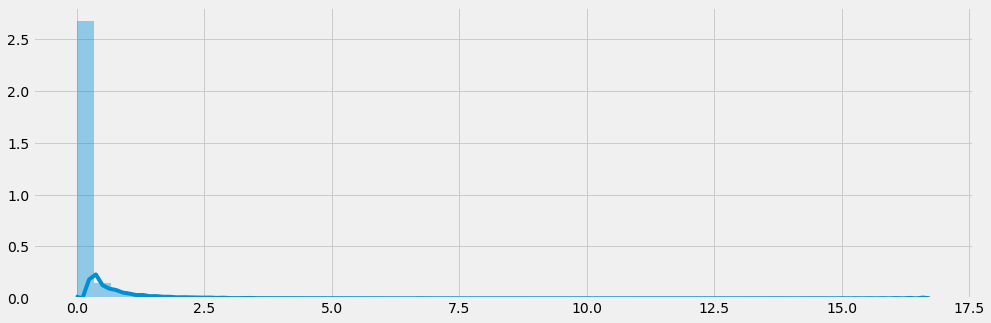

In [0]:
plt.figure(figsize = (15,5))
sns.distplot(precipitation)

Text(0, 0.5, 'Land Type')

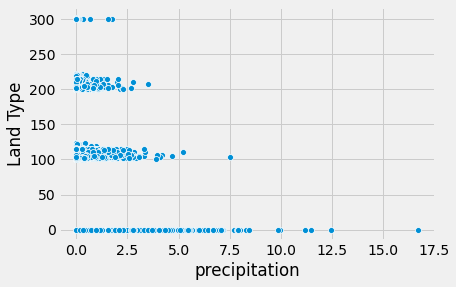

In [0]:
sns.scatterplot(precipitation,train_numeric[:,0])
plt.xlabel('precipitation')
plt.ylabel('Land Type')

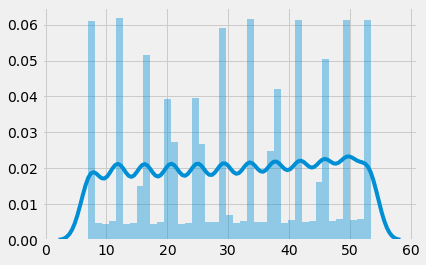

In [0]:
sns.distplot(train_numeric[:,2])

In [0]:
precipitation = np.sum(np.sum(train[:,:,:,14],axis = 1), axis = 1)/1600
null_index = precipitation < 0

In [0]:
print('Null data ratio = ',null_index.sum()/len(null_index) * 100, '%')

Null data ratio =  0.5108724128897039 %


In [0]:
null_train = train[precipitation < 0]

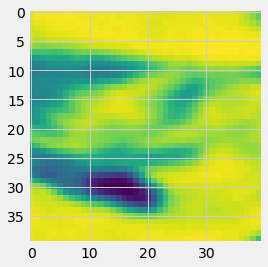

In [0]:
plt.imshow(null_train[215,:,:,1])

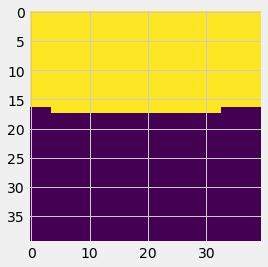

In [0]:
plt.imshow(null_train[215,:,:,14])

## 모델만들기

In [0]:
def build_model(input_layer, start_neurons):
    
    # 40 x 40 -> 20 x 20
    conv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(input_layer)
    conv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(conv1)
    pool1 = BatchNormalization()(conv1)
    pool1 = MaxPooling2D((2, 2))(pool1)
    pool1 = Dropout(0.25)(pool1)

    # 20 x 20 -> 10 x 10
    conv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(pool1)
    conv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(conv2)
    pool2 = BatchNormalization()(conv2)
    pool2 = MaxPooling2D((2, 2))(pool2)
    pool2 = Dropout(0.25)(pool2)

    # 10 x 10 
    convm = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(pool2)

    # 10 x 10 -> 20 x 20
    deconv2 = Conv2DTranspose(start_neurons * 2, (3, 3), strides=(2, 2), padding="same")(convm)
    uconv2 = concatenate([deconv2, conv2])
    uconv2 = Dropout(0.25)(uconv2)
    uconv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(uconv2)
    uconv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(uconv2)
    uconv2 = BatchNormalization()(uconv2)

    # 20 x 20 -> 40 x 40
    deconv1 = Conv2DTranspose(start_neurons * 1, (3, 3), strides=(2, 2), padding="same")(uconv2)
    uconv1 = concatenate([deconv1, conv1])
    uconv1 = Dropout(0.25)(uconv1)
    uconv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(uconv1)
    uconv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(uconv1)
    uconv1 = BatchNormalization()(uconv1)
    uconv1 = Dropout(0.25)(uconv1)
    output_layer = Conv2D(1, (1,1), padding="same", activation='relu')(uconv1)
    
    return output_layer

input_layer = Input((40, 40, 10))
output_layer = build_model(input_layer, 32)

In [0]:
model = Model(input_layer, output_layer)

In [0]:
from sklearn.metrics import f1_score

def mae(y_true, y_pred) :
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    y_true = y_true.reshape(1, -1)[0]
    y_pred = y_pred.reshape(1, -1)[0]
    over_threshold = y_true >= 0.1
    return np.mean(np.abs(y_true[over_threshold] - y_pred[over_threshold]))

def fscore(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    y_true = y_true.reshape(1, -1)[0]
    y_pred = y_pred.reshape(1, -1)[0]
    remove_NAs = y_true >= 0
    y_true = np.where(y_true[remove_NAs] >= 0.1, 1, 0)
    y_pred = np.where(y_pred[remove_NAs] >= 0.1, 1, 0)
    return(f1_score(y_true, y_pred))

def maeOverFscore(y_true, y_pred):
    return mae(y_true, y_pred) / (fscore(y_true, y_pred) + 1e-07)

def fscore_keras(y_true, y_pred):
    score = tf.py_function(func=fscore, inp=[y_true, y_pred], Tout=tf.float32, name='fscore_keras')
    return score

def maeOverFscore_keras(y_true, y_pred):
    score = tf.py_function(func=maeOverFscore, inp=[y_true, y_pred], Tout=tf.float32,  name='custom_mse') 
    return score

In [0]:
model.compile(loss="mae", optimizer="adam", metrics=[maeOverFscore_keras, fscore_keras])

## 데이터 제네레이터 만들기

In [12]:
from sklearn.model_selection import KFold
kf = KFold(n_splits=5)
model_history = []
fold_number = 0

for train_index, test_index in kf.split(train):
    print(f'\nFold {fold_number}')
    fold_number = fold_number + 1
#-----------------------------------------------------------------------------
    def trainGenerator():
        for file in train[train_index]:
            target= file[:,:,-1].reshape(40,40,1)
            cutoff_labels = np.where(target < 0, 0, target)
            feature = file[:,:,:10]#########################land type 추가
            if (cutoff_labels > 0).sum() < 50:
                continue
            yield (feature, cutoff_labels)
    train_dataset = tf.data.Dataset.from_generator(trainGenerator,
                                                (tf.float32, tf.float32),
                                                (tf.TensorShape([40,40,10]),########################land type 추가
                                                    tf.TensorShape([40,40,1])))
    train_dataset = train_dataset.batch(512).prefetch(1)
#-----------------------------------------------------------------------------
    def testGenerator():
        for file in train[test_index]:
            target= file[:,:,-1].reshape(40,40,1)
            cutoff_labels = np.where(target < 0, 0, target)
            feature = file[:,:,:10]#########################land type 추가
            if (cutoff_labels > 0).sum() < 50:
                continue
            yield (feature, cutoff_labels)
    test_dataset = tf.data.Dataset.from_generator(testGenerator,
                                                (tf.float32, tf.float32),
                                                (tf.TensorShape([40,40,10]),########################land type 추가
                                                    tf.TensorShape([40,40,1])))
    test_size = len(test_index)
    test_dataset = test_dataset.batch(test_size).prefetch(1)
#-----------------------------------------------------------------------------

    
    
    history = model.fit(train_dataset, epochs = 10, verbose=1, validation_data = test_dataset)

    #history = model.fit(train_dataset, epochs = 5, ,batch_size = 11, verbose=1)
    model_history.append(history)
    #del data
    del train_dataset
    del test_dataset
    gc.collect()


Fold 0
Epoch 1/10
44/44 [==============================] - 42s 945ms/step - loss: 0.4592 - maeOverFscore_keras: 6.3886 - fscore_keras: 0.3527 - val_loss: 0.2905 - val_maeOverFscore_keras: 4.0041 - val_fscore_keras: 0.4712
Epoch 2/10
44/44 [==============================] - 38s 853ms/step - loss: 0.3020 - maeOverFscore_keras: 3.2665 - fscore_keras: 0.5533 - val_loss: 0.2853 - val_maeOverFscore_keras: 3.6380 - val_fscore_keras: 0.5103
Epoch 3/10
44/44 [==============================] - 37s 850ms/step - loss: 0.2880 - maeOverFscore_keras: 3.0440 - fscore_keras: 0.5790 - val_loss: 0.2814 - val_maeOverFscore_keras: 3.3206 - val_fscore_keras: 0.5494
Epoch 4/10
44/44 [==============================] - 37s 843ms/step - loss: 0.2773 - maeOverFscore_keras: 2.7557 - fscore_keras: 0.6168 - val_loss: 0.3065 - val_maeOverFscore_keras: 4.5501 - val_fscore_keras: 0.4434
Epoch 5/10
44/44 [==============================] - 37s 848ms/step - loss: 0.2692 - maeOverFscore_keras: 2.5503 - fscore_keras: 0.64

In [0]:
model

## submission 만들기

In [0]:
# 훈련에서 사용하는 0~8번 채널만을 뽑아서 X_test에 저장하기
test_submit = np.load('/content/drive/My Drive/2020 Kaggle Study/data/test.npy')
X_test = test_submit[:,:,:,:10]
del test_submit
gc.collect()

pred = model.predict(X_test)

In [0]:
model.save('model_landtype.h5')
!cp model_landtype.h5 '/content/drive/My Drive/2020 Kaggle Study/model'

## submission 만들기

In [0]:
submission = pd.read_csv('/content/drive/My Drive/2020 Kaggle Study/data/sample_submission.csv')

In [0]:
submission.iloc[:,1:] = pred.reshape(-1, 1600)

In [0]:
submission.to_csv('Dacon_landtype.csv', index = False)

In [0]:
# 제출파일 구글 드라이브에 올리기
!cp Dacon_landtype.csv '/content/drive/My Drive/2020 Kaggle Study/submission'